In [176]:
!pip install seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [177]:
import pandas as pd
import numpy as np
import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

pd.set_option('display.max_columns', 100)

In [178]:
# raw data is taken from Stocker package which uses Quandl API
# agg_df = pd.read_csv('./agg_data2.csv', index_col=0)
agg_df = pd.read_csv('./agg_data.csv', index_col=0)

C:\Users\mohan\AppData\Local\Temp\ipykernel_21484\492590025.py:3: DtypeWarning: Columns (1,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  agg_df = pd.read_csv('./agg_data.csv', index_col=0)


In [179]:
agg_df.head()

,date,open,high,low,close,volume,ex-dividend,split ratio,adj. open,adj. high,adj. low,adj. close,adj. volume,ds,y,daily change,ticker,Date,Open,High,Low,Close,Adj Close,Volume
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,
0,1990-11-05,3.88,4.25,3.25,4.25,34800.0,0.0,1.0,3.88,4.25,3.25,4.25,34800.0,1990-11-05,4.25,0.37,DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-11-06,3.50,4.25,3.50,3.62,21600.0,0.0,1.0,3.50,4.25,3.50,3.62,21600.0,1990-11-06,3.62,0.12,DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-11-07,3.50,4.00,3.50,4.00,20400.0,0.0,1.0,3.50,4.00,3.50,4.00,20400.0,1990-11-07,4.00,0.50,DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-11-08,4.00,4.00,3.75,4.00,16800.0,0.0,1.0,4.00,4.00,3.75,4.00,16800.0,1990-11-08,4.00,0.00,DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-11-09,4.00,4.00,3.50,3.50,300.0,0.0,1.0,4.00,4.00,3.50,3.50,300.0,1990-11-09,3.50,-0.50,DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
agg_df['date'] = pd.to_datetime(agg_df['date'])


In [181]:
# Narrowing data set to 2012 - 2017
agg_df2 = (
    agg_df
    .pipe(lambda x: x.assign(year=x['date'].dt.year))
    .query("year >= 2012")
    [['ticker', 'date', 'year', 'open', 'close']]
)

In [182]:
agg_df2.head()

,ticker,date,year,open,close
Unnamed: 0,,,,,
5333,DDD,2012-01-03,2012.0,14.85,15.36
5334,DDD,2012-01-04,2012.0,15.23,15.49
5335,DDD,2012-01-05,2012.0,15.42,16.09
5336,DDD,2012-01-06,2012.0,16.12,16.01
5337,DDD,2012-01-09,2012.0,16.00,15.81


In [183]:
# Getting the first day and last day of each year in the data set
first_date_list = [agg_df2.query(f"year == {2012+i}").date.min() for i in range(6)]
last_date_list = [agg_df2.query(f"year == {2012+i}").date.max() for i in range(6)]
first_date_df = pd.DataFrame({"date": first_date_list}) 
last_date_df = pd.DataFrame({"date": last_date_list})

In [184]:
# Ensure that 'date' columns in first_date_df and last_date_df are of datetime type
first_date_df['date'] = pd.to_datetime(first_date_df['date'])
last_date_df['date'] = pd.to_datetime(last_date_df['date'])


In [185]:
print(first_date_df.tail())
print(last_date_df.tail())


        date
1 2013-01-02
2 2014-01-02
3 2015-01-02
4 2016-01-04
5 2017-01-03
        date
1 2013-12-31
2 2014-12-31
3 2015-12-31
4 2016-12-30
5 2017-12-29


In [186]:
print(agg_df2.isnull().sum())
print(agg_df2.size)
print(last_date_df.isnull().sum())


ticker    0
date      0
year      0
open      0
close     0
dtype: int64
6525330
date    0
dtype: int64


In [187]:
# Filter first day data
agg_first_date_df = (
    agg_df2
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x['date'].dt.year))
    .rename(columns={"open": "open_first_day", "close": "close_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day', 'close_first_day']]
)

# Filter last day data
agg_last_date_df = (
    agg_df2
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x['date'].dt.year))
    .rename(columns={"open": "open_last_day", "close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_last_day', 'close_last_day']]
)

# Calculating yearly return and averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x['close_last_day']-x['open_first_day']))
    .pipe(lambda x: x.assign(gains_pctg=x['gains_dollar']/x['open_first_day']))
    .groupby("ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# Calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x['close_last_day']-x['open_first_day']))
    .pipe(lambda x: x.assign(gains_pctg=x['gains_dollar']/x['open_first_day']))
    [['ticker', 'gains_pctg']]
    .groupby("ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "variance"})
)

# Final merged DataFrame
agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='ticker', how='inner')
)

C:\Users\mohan\AppData\Local\Temp\ipykernel_21484\870281030.py:41: FutureWarning: The provided callable <function var at 0x0000027810D6C7C0> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  .agg(np.var)


In [188]:
agg_df2.head()

,ticker,date,year,open,close
Unnamed: 0,,,,,
5333,DDD,2012-01-03,2012.0,14.85,15.36
5334,DDD,2012-01-04,2012.0,15.23,15.49
5335,DDD,2012-01-05,2012.0,15.42,16.09
5336,DDD,2012-01-06,2012.0,16.12,16.01
5337,DDD,2012-01-09,2012.0,16.00,15.81


In [189]:
agg_df2.to_csv('./agg_df2_2012_onwards.csv', index=False)

In [190]:
agg_df3.head(3)

,ticker,avg_yearly_returns,variance
0,A,0.133075,0.068609
1,AAN,0.084080,0.057674
2,AAP,0.103154,0.116833


In [191]:
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ticker              836 non-null    object 
 1   avg_yearly_returns  836 non-null    float64
 2   variance            836 non-null    float64
dtypes: float64(2), object(1)
memory usage: 19.7+ KB


In [192]:
# from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
# from sklearn.cluster import KMeans
# from sklearn import metrics

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

In [193]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various numbers of clusters using K-Means.
    Performance is evaluated by within-cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except KeyError:
        pass  # Only drop 'cluster' if it exists
    
    X = df.iloc[:, 1:]
    
    # Robust scaling is used to prevent outliers from affecting the clustering process
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_scores = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        
        # Calculate silhouette score only if there are more than one label
        if len(set(kmeans.labels_)) > 1:
            silhouette_scores[k] = metrics.silhouette_score(X_rb, kmeans.labels_)
        else:
            silhouette_scores[k] = float('nan')  # Set to NaN if not enough clusters

    # Plotting the results
    plt.figure(figsize=(10, 6))
    
    # Plotting SSE
    ax1 = plt.subplot(211)
    plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()), marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE Within Cluster")
    plt.title("Within Cluster SSE After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    # Plotting Silhouette Score
    ax2 = plt.subplot(212)
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

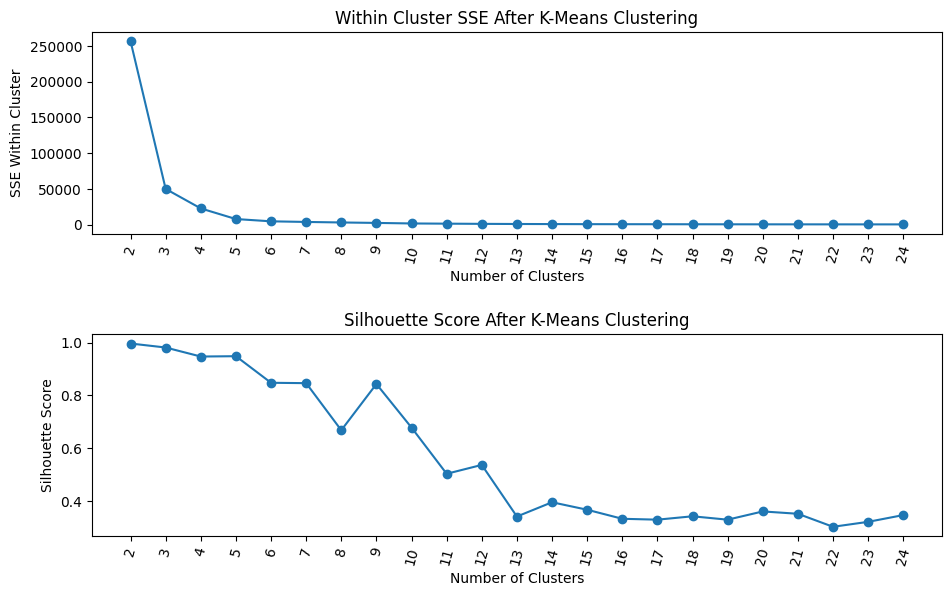

In [194]:
plot_cluster(agg_df3, max_loop=25)

1. From the first graph, `Within Cluster SSE After K-Means Clustering`, we can see that as the number of clusters increase pass 4, the sum of square of errors within clusters plateaus off. 

2. As for the second graph, `Silhouette Score After K-Means Clustering`, we can see that there are various parts of the graph where a kink can be seen. 

In [195]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        pass
    
    X = df.iloc[:, 1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)  
    kmeans.fit(X_rb) 
    
    score = metrics.silhouette_score(X_rb, kmeans.labels_)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("Clustering Performance")
    print("-----------------------------------")
    print("Silhouette Score: " + str(round(score, 2)))
    print("SSE Within Cluster: " + str(round(sse_within_cluster)))
    
    return df

In [196]:
first_trial = apply_cluster(agg_df3, clusters=17)

Clustering Performance
-----------------------------------
Silhouette Score: 0.33
SSE Within Cluster: 541


In [197]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,10,-0.040056,0.116135,117
1,13,0.084649,0.046015,339
2,9,0.202333,0.384218,48
3,0,0.206606,0.049576,191
4,14,0.265462,0.174574,96
5,5,0.289772,0.782710,15
6,16,0.334095,1.387970,8
7,7,0.593037,3.769099,4
8,11,0.611078,2.037400,5
9,12,0.739092,6.760454,1


From 

In [198]:
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

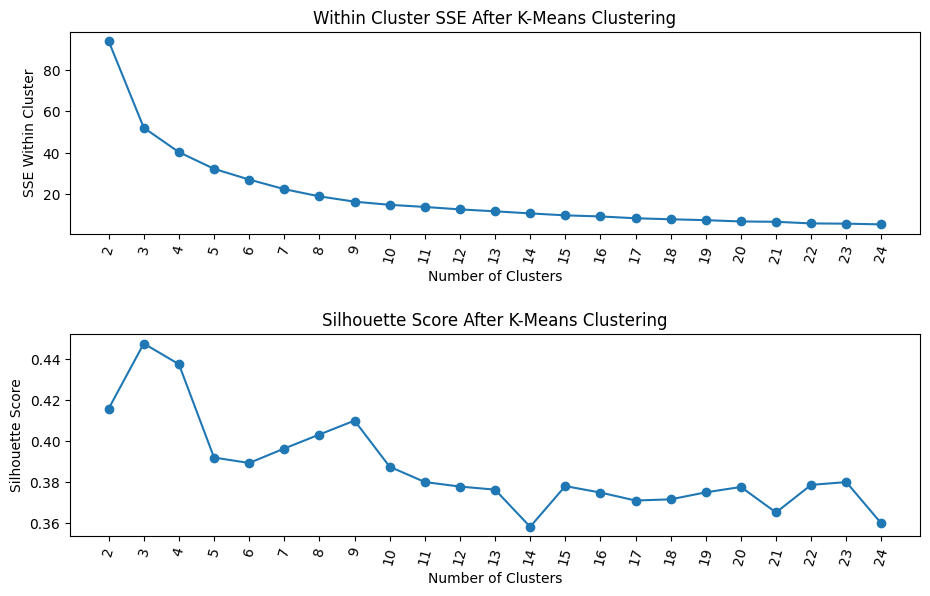

In [217]:
plot_cluster(agg_df3_sub, max_loop=25)

In [200]:
second_trial= apply_cluster(agg_df3_sub, clusters=6)

Clustering Performance
-----------------------------------
Silhouette Score: 0.39
SSE Within Cluster: 27


In [201]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,1,0.175063,0.055344,34
1,0,0.177040,0.092011,34
2,4,0.181179,0.021669,58
3,3,0.231269,0.058507,25
4,5,0.260107,0.025256,22
5,2,0.304326,0.065769,18


In [202]:
second_trial.head(3)

,ticker,avg_yearly_returns,variance,cluster
0,ABC,0.186759,0.074800,0
1,ABG,0.225886,0.103646,0
2,ACN,0.192766,0.005483,4


In [203]:
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

C:\Users\mohan\AppData\Local\Temp\ipykernel_21484\1849563909.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  us_yield_curve_5years_df


In [204]:
def get_sharpe_ratio_df(df):
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [205]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [206]:
def get_transform_df(df_w_sharpe_ratio):
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['variance', 'cluster']]
        .pipe(lambda x: x.assign(type='variance'))
        .rename(columns={"variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [207]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [208]:
def cluster_perf(transform_df, sharpe_ratio_df):
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

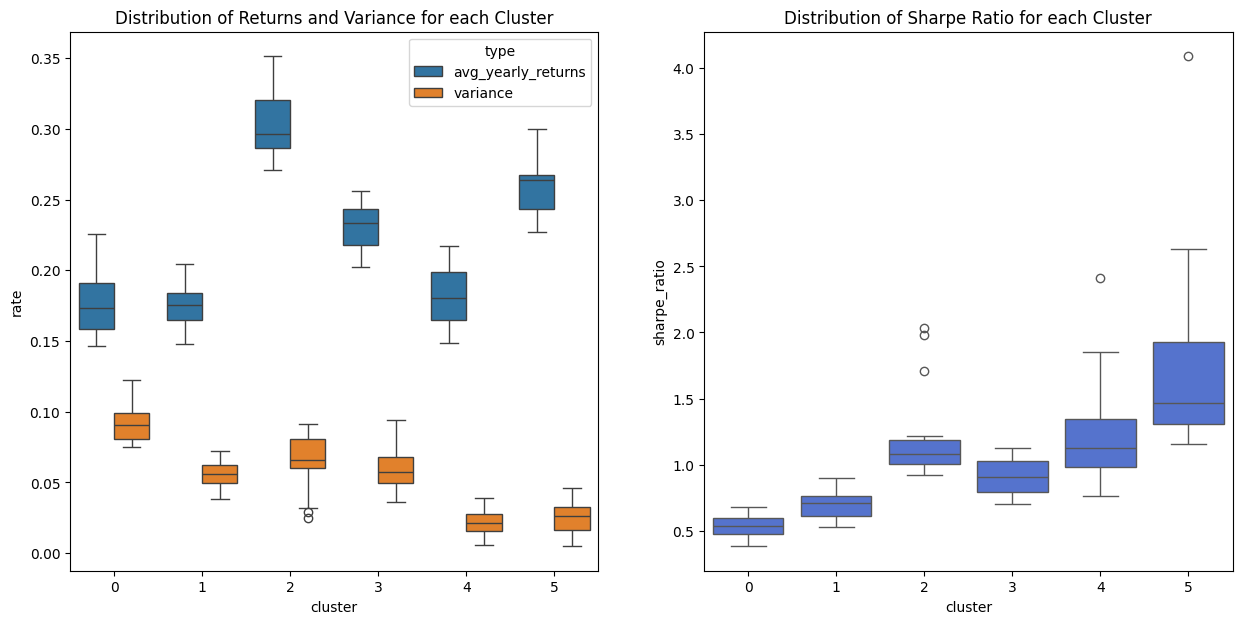

In [209]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

In [210]:
best_sub_cluster = second_trial.query("cluster == 2")

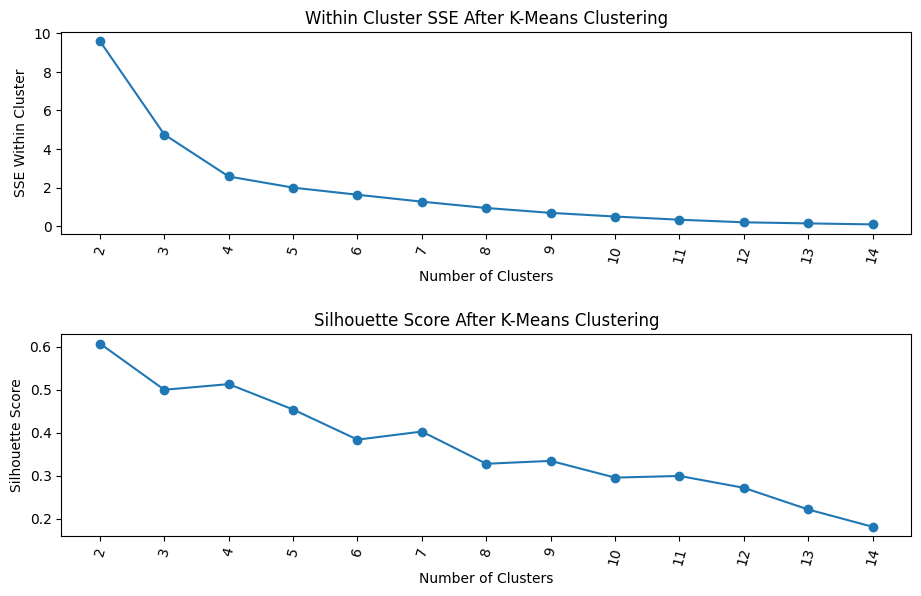

In [219]:
plot_cluster(best_sub_cluster, max_loop=15)

In [220]:
third_trial = apply_cluster(best_sub_cluster, clusters=4)

Clustering Performance
-----------------------------------
Silhouette Score: 0.51
SSE Within Cluster: 3


C:\Users\mohan\AppData\Local\Temp\ipykernel_21484\2718123876.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


In [221]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,variance,ticker
0,3,0.282359,0.080228,4
1,2,0.292712,0.062396,7
2,0,0.323193,0.085092,4
3,1,0.335557,0.028598,3


In [222]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [223]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

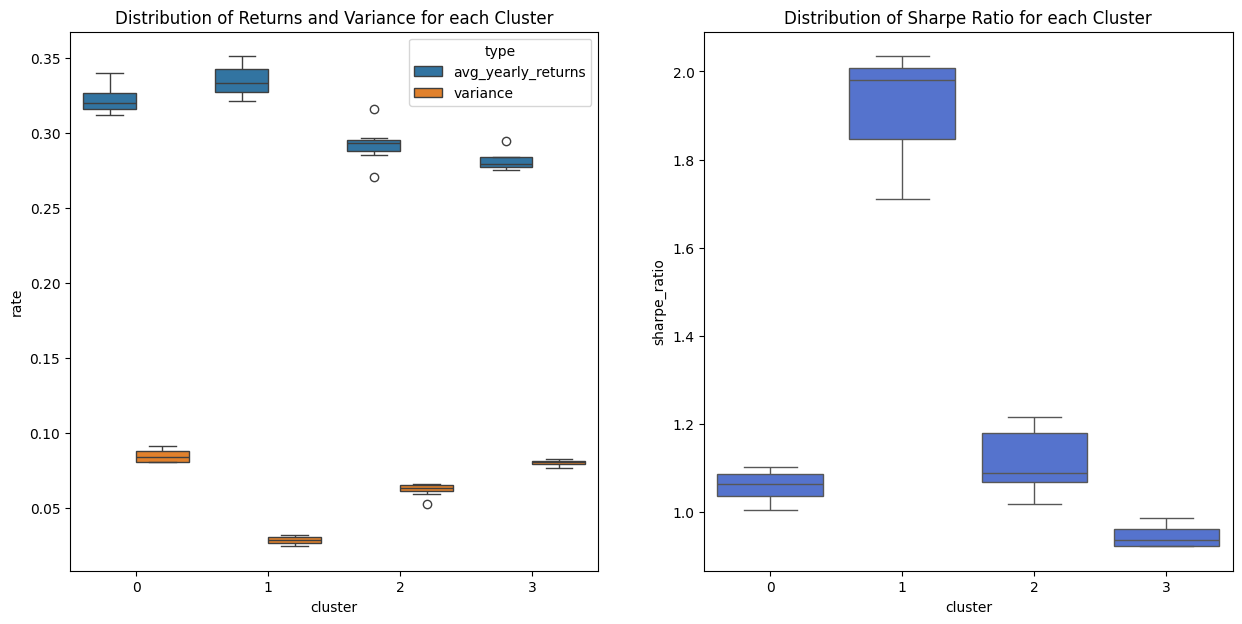

In [224]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)